In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np
import data
from dataset import rdDataset
from model import rdcnn
from math import log10


# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:1" if use_cuda else "cpu")
# cudnn.benchmark = True
path = './data'

# Parameters

params = {'test_split': .25,
          'shuffle_dataset': True,
          'batchsize': 2610,
          'random_seed': 42,
          'numworkers':16}
max_epoches = 100
learning_rate = 1e-3
drop_rate = 0.0
# test_split = .2
# shuffle_dataset = True
# random_seed= 42
# batchsize = 2610

print('===> Loading datasets')
# Load All Dataset
dataset = rdDataset(path)

# Creating data indices for training and validation splits:

# training_data_loader, testing_data_loader = data.DatasetSplit(dataset, test_split, shuffle_dataset, random_seed, batchsize)
training_data_loader, testing_data_loader = data.DatasetSplit(dataset, **params)

# training_generator = data.DataLoader(training_set, **params)

# validation_set = Dataset(path)
# validation_generator = data.DataLoader(validation_set, **params)

print('===> Building model')
model = rdcnn(drop_rate).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-5)



def train(epoch):
    epoch_loss = 0
    for iteration, batch in enumerate(training_data_loader, 1):
        input, target = batch[0].to(device, torch.float), batch[1].to(device, torch.float)
        optimizer.zero_grad()
        loss = criterion(model(input), target)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

        print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, iteration, len(training_data_loader), loss.item()))

    print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(training_data_loader)))
    
def test():
    avg_error = 0
    avg_loss = 0
    with torch.no_grad():
        for batch in testing_data_loader:
            input, target = batch[0].to(device, torch.float), batch[1].to(device, torch.float)

            prediction = model(input)
#             print(len(prediction))
            for j in range(len(prediction)):
                avg_error += torch.mean((prediction[j]-target[j])**2/torch.max(target[j]))
            avg_error /= len(prediction)
            mse = criterion(prediction, target)
            avg_loss += mse
# #             psnr = 10 * log10(1 / mse.item())
# #             avg_psnr += psnr
   
#     print(len(training_data_loader))
#     print(len(testing_data_loader))
    print("===> Avg. Loss: {:.4f} ".format(avg_loss / len(testing_data_loader)))
    print("===> Avg. Error: {:.4f} ".format(avg_error / len(testing_data_loader)))
    return avg_loss / len(testing_data_loader),avg_error / len(testing_data_loader)

def checkpoint(epoch):
    model_out_path = "./checkpoint_largedata/model_epoch_{}.pth".format(epoch)
    torch.save(model, model_out_path)
    print("Checkpoint saved to {}".format(model_out_path))
    

===> Loading datasets
===> Building model


In [ ]:
L_train_loss = []
L_test_loss = []
L_test_error = []
for epoch in range(1, max_epoches + 1):
    train_loss = train(epoch)
    test_loss,test_error = test()
    checkpoint(epoch)
    L_train_loss.append(train_loss)
    L_test_loss.append(test_loss)
    L_test_error.append(test_error)

In [21]:
file = open("all_error.txt", "w")

for i in range(len(L_test_loss)):
    print(L_train_loss[i][0])
    print(L_train_loss[i][1])
    print(L_test_loss[i].item())
    print(L_test_error[i].item())

for i in range(len(L_test_loss)):
#     file.write("%d %f %f %f\n",L_train_loss[i][0],L_train_loss[i][1],L_test_loss[i].item(),L_test_error[i].item() )
    file.write(str(L_train_loss[i][0])+" "+str(L_train_loss[i][1])+" "+str(L_test_loss[i].item())+" "+str(L_test_error[i].item())+"\n")


file.close()

1
0.20290788610776264
0.15691439807415009
0.03981466591358185
2
0.1357136160135269
0.11057571321725845
0.027417490258812904
3
0.09675284524758657
0.08077999949455261
0.01950678415596485
4
0.07253091384967168
0.06358396261930466
0.014802669174969196
5
0.060468025008837384
0.05688995122909546
0.012379095889627934
6
0.05569896399974823
0.05361027270555496
0.011653379537165165
7
0.0528607169787089
0.051416218280792236
0.01170522440224886
8
0.05098112548391024
0.05011391267180443
0.011070461012423038
9
0.04976707647244136
0.049094609916210175
0.011043017730116844
10
0.04867903962731361
0.04834636300802231
0.01091797836124897
11
0.04808414727449417
0.04800692945718765
0.010415635071694851
12
0.047733295957247415
0.047693777829408646
0.01064979936927557
13
0.047403796762228015
0.04742874950170517
0.010144438594579697
14
0.047208341459433235
0.04712609574198723
0.010777372866868973
15
0.046985583007335664
0.04695742949843407
0.01002341229468584
16
0.04685713971654574
0.04687207192182541
0.0100

/export/home/math/angranl/anaconda3/envs/mygeo/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


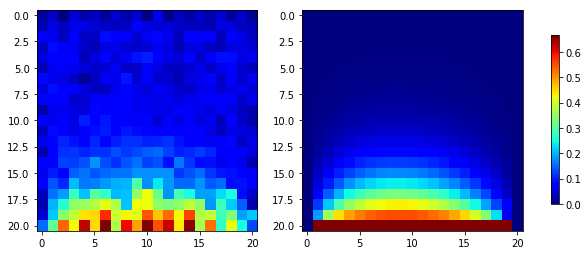

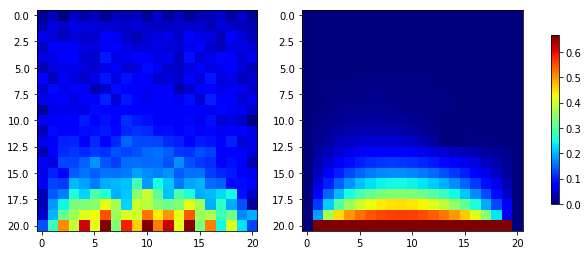

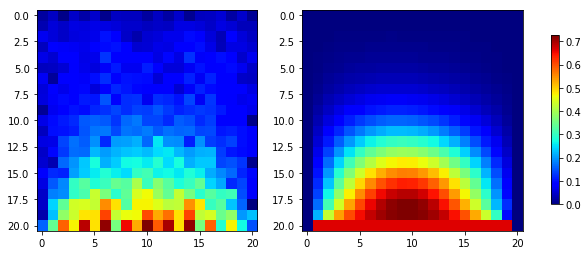

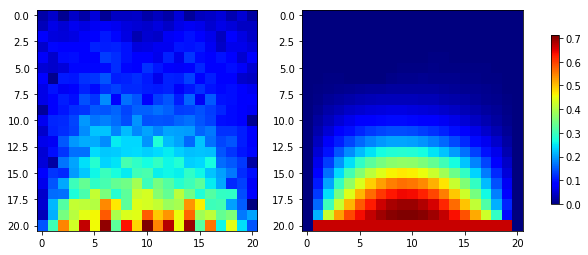

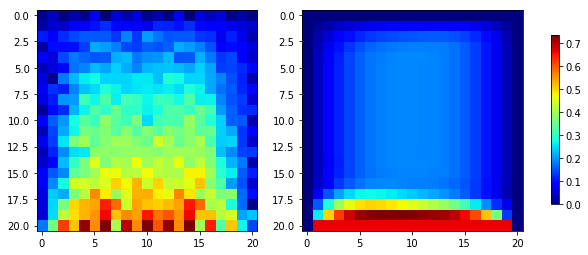

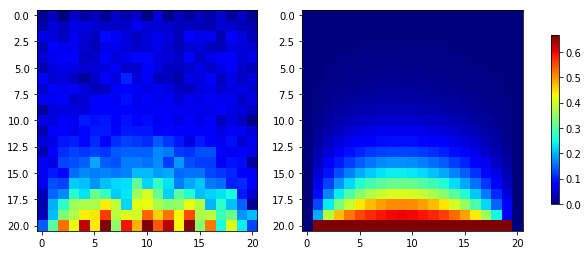

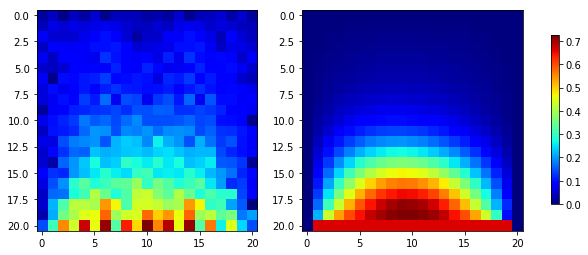

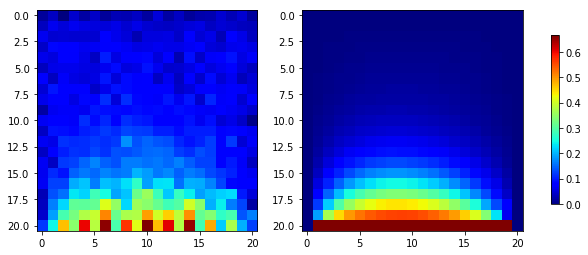

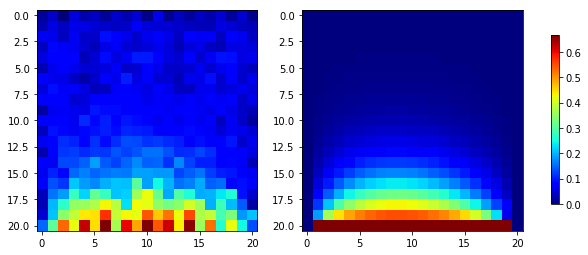

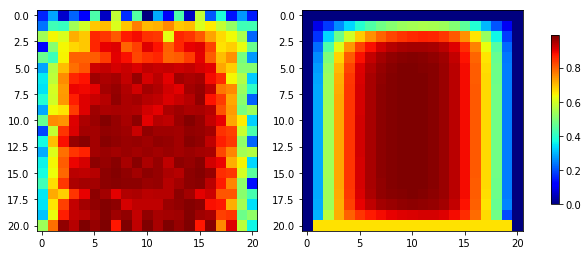

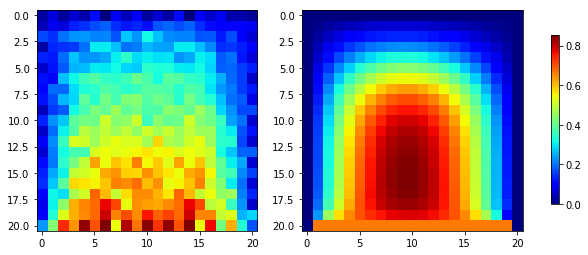

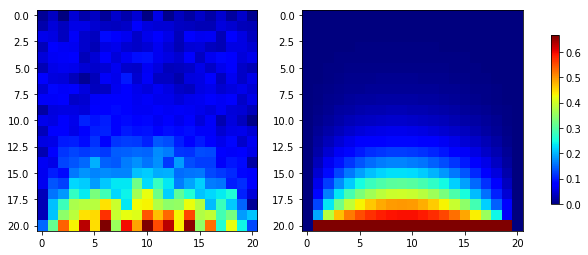

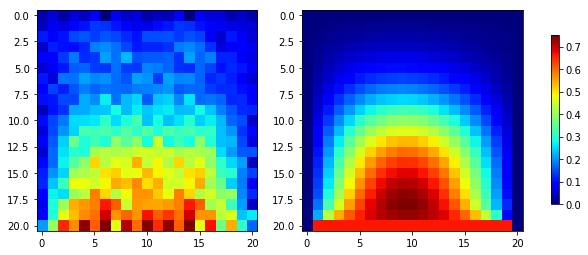

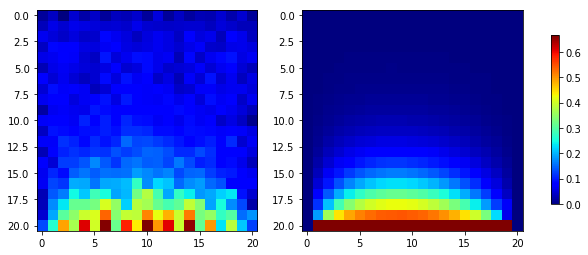

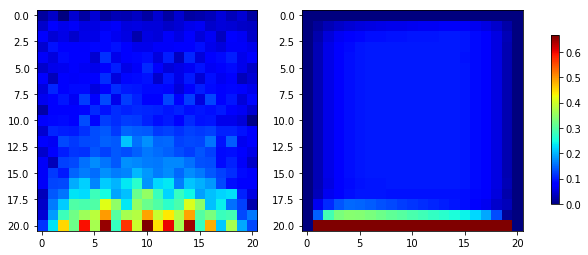

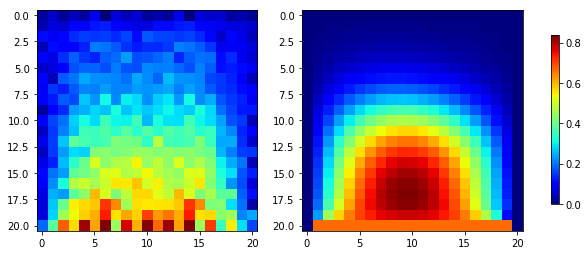

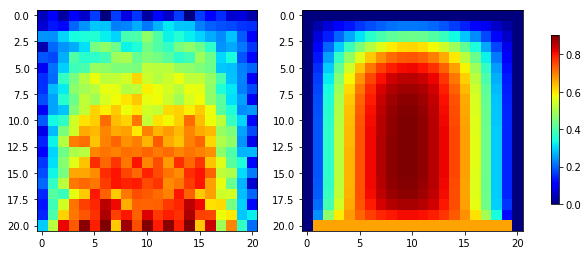

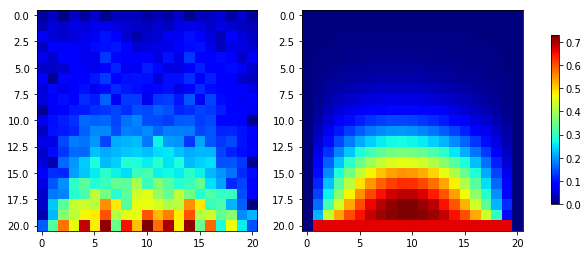

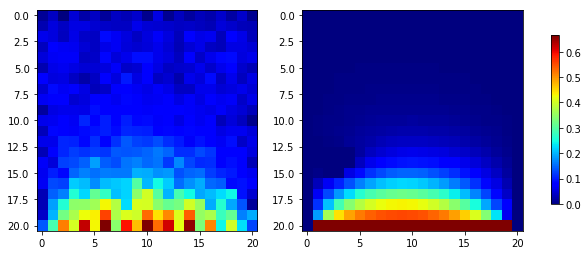

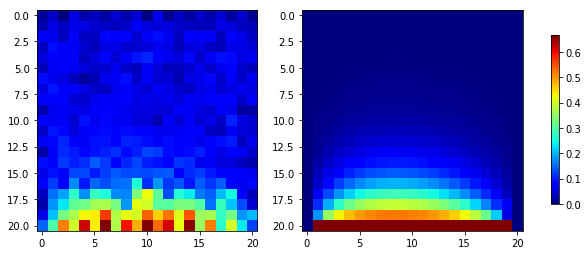

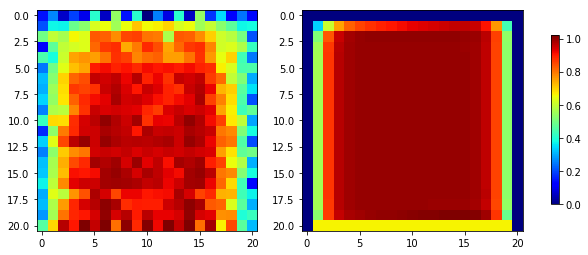

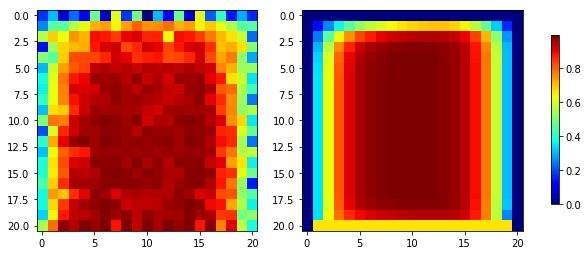

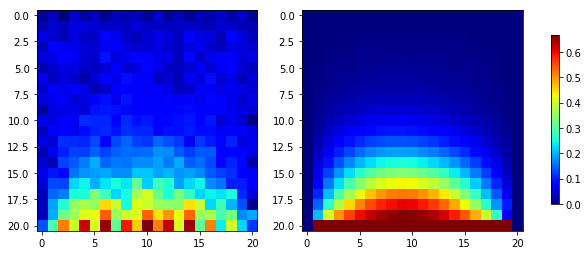

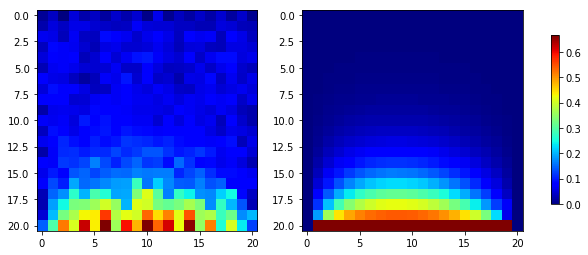

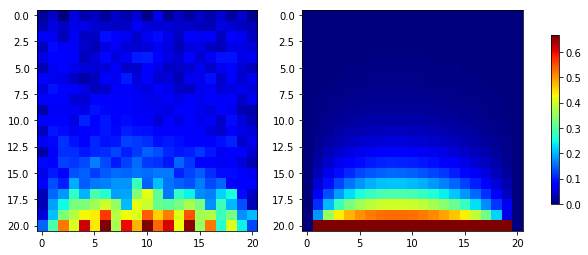

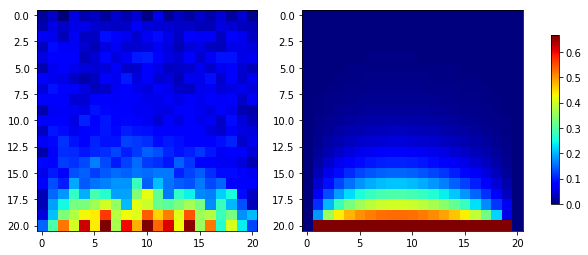

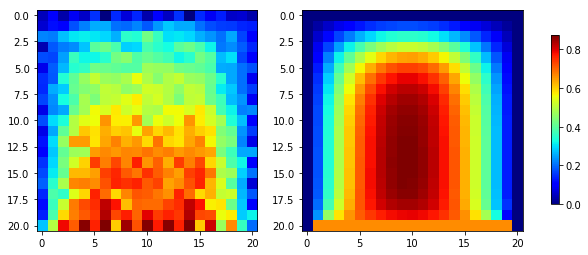

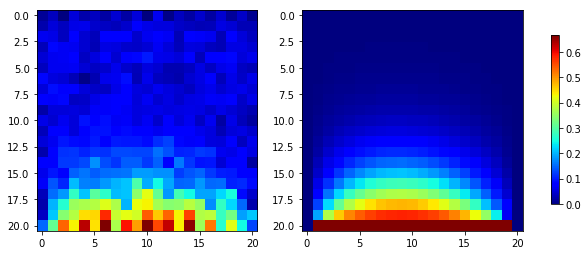

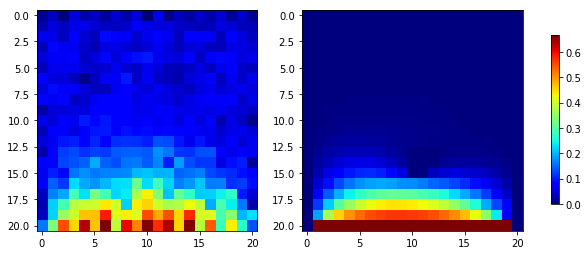

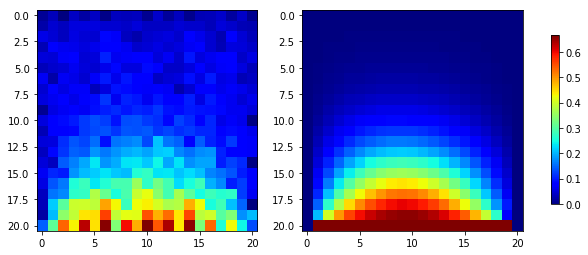

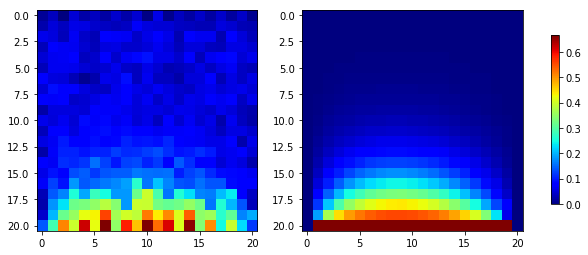

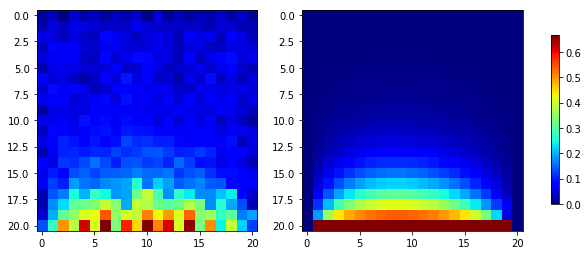

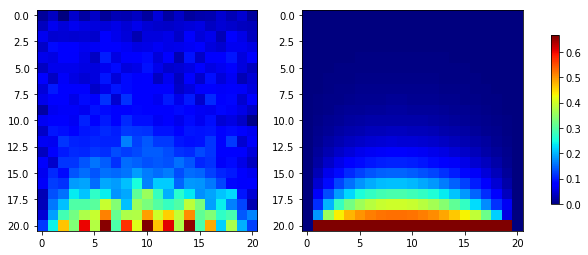

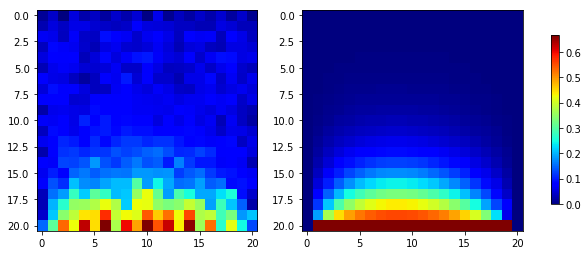

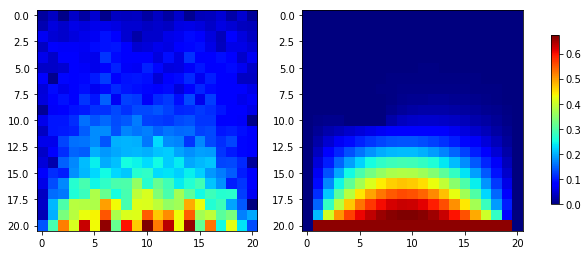

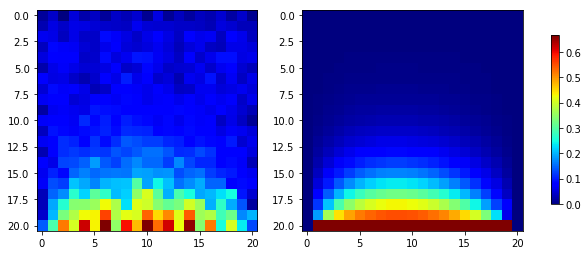

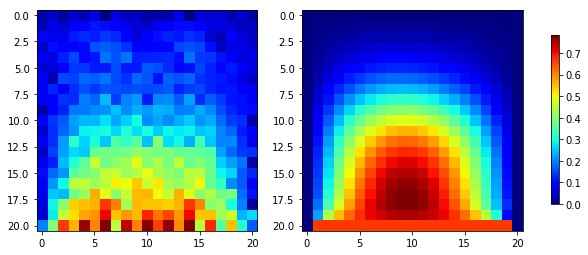

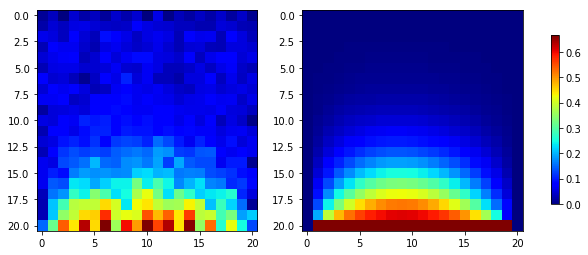

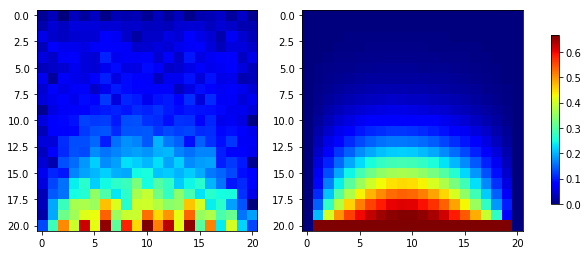

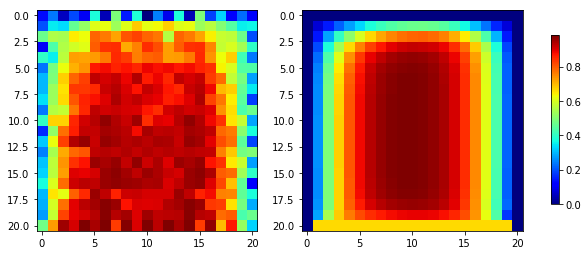

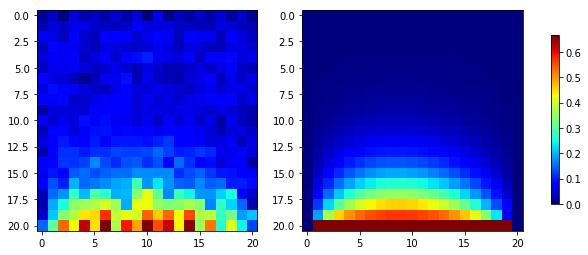

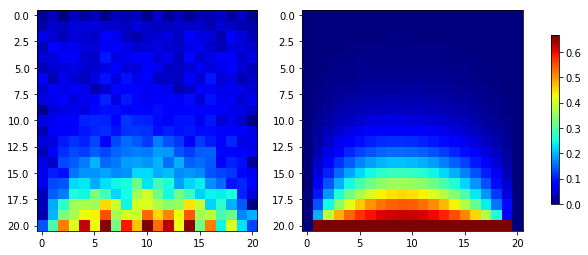

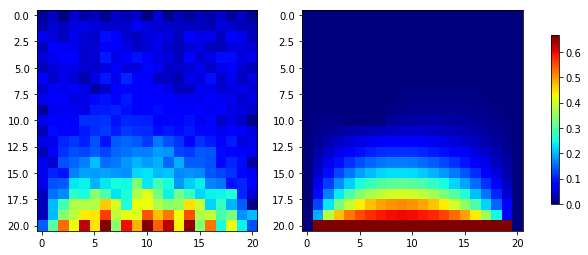

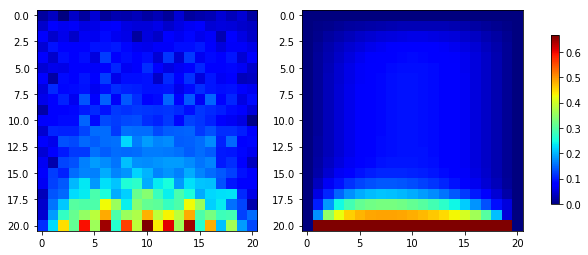

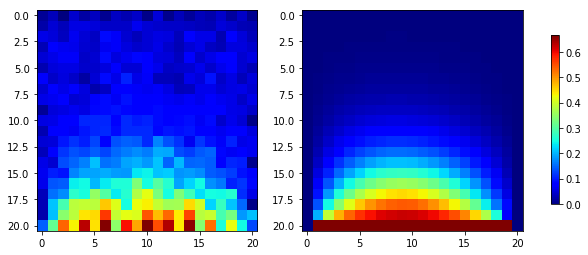

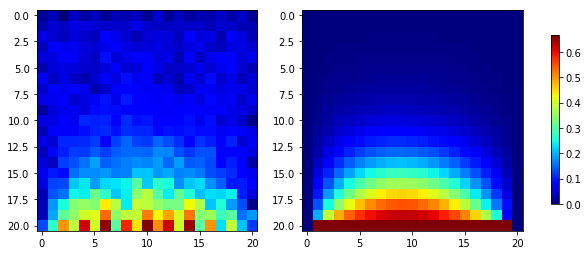

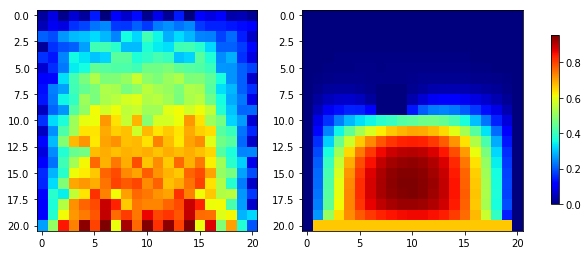

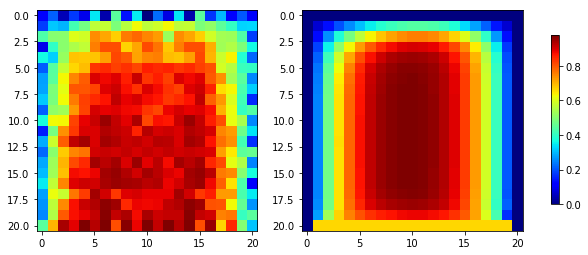

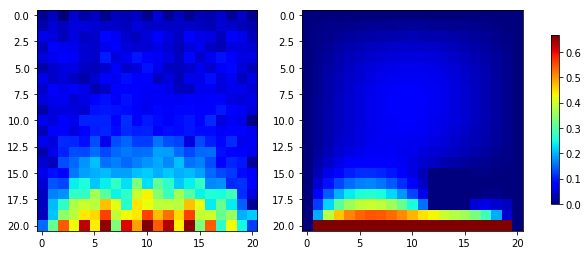

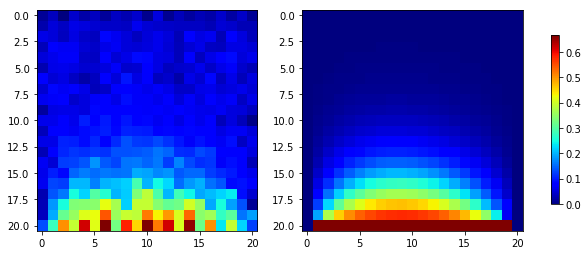

In [4]:
from matplotlib import pyplot as plt
with torch.no_grad():
    for batch in testing_data_loader:
        input, target = batch[0].to(device, torch.float), batch[1].to(device, torch.float)

        prediction = model(input)
        
for t in range(50):
    fig, ax = plt.subplots(1,2, figsize=(10,5))

    im = ax[0].imshow(prediction[t][0].cpu(),cmap = "jet")
    im = ax[1].imshow(target[t][0].cpu(),cmap = "jet")

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.84, 0.27, 0.01, 0.47])
    fig.colorbar(im, cax=cbar_ax)

plt.show()

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))

num_epoch_list = np.arrange(1,60)

plt.plot(num_epochs_list, error_list)
    
# plt.title("Loss ")
plt.xlabel('Epoch', fontsize=30)
plt.ylabel('accuracy', fontsize=30)

plt.rcParams.update({'font.size': 25})
plt.show()

AttributeError: module 'numpy' has no attribute 'arrange'